In [1]:
from napari_convpaint import conv_paint, conv_paint_utils, conv_paint_param
import numpy as np
import matplotlib.pyplot as plt
import skimage

Cellpose is not installed and is not available as feature extractor.
Run 'pip install napari-convpaint[cellpose]' to install it.


<div class="alert alert-block alert-warning">
<b>WARNING:</b> Convpaint API will significantly change in the next weeks! This <b>notebook is not up to date</b> and many parts will currently not work. [State: 2024-11-09]
</div>

# Using Convpaint programmatically
## Load a saved model and use it in a loop
A nice workflow is to interactively train the model in the Napari GUI, then use it programmatically in batch processing.
Here we load a model trained on sample data and apply it to an image:

In [2]:
random_forest,model,param,model_state = conv_paint.load_model("../sample_data/lily_VGG16.pickle")

img = skimage.data.lily() # Load example image
img = np.moveaxis(img,-1,0) # Move channel axis to first position

mean,std = conv_paint_utils.compute_image_stats(img,ignore_n_first_dims=1)
img_norm = conv_paint_utils.normalize_image(img,mean,std)

prediction = model.predict_image(image=img_norm,classifier=random_forest,param=param)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..4095].
/var/folders/zy/d2yp5vws25l6vkr2g5l4t39c0000gn/T/ipykernel_65814/1569117739.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 3)


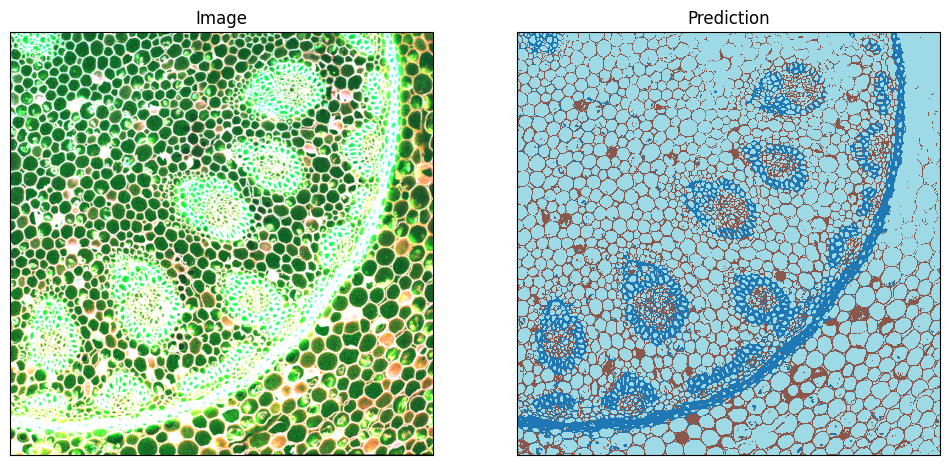

In [3]:
# show the image and the annotations
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the image
axes[0].imshow(skimage.data.lily()[:,:,:3], cmap='gray')
axes[0].set_title('Image')

cmap = plt.cm.get_cmap('tab20', 3)
cmap.set_under('white')

# Plot the prediction
axes[1].imshow(prediction, cmap=cmap,interpolation='nearest')#,vmin=1,vmax=3)
axes[1].set_title('Prediction')

#disable x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

## Create and train a new model using the API

We can also create new models completely programatically, e.g. to compare the performance of different models.

First let's look at all the available models:

In [4]:
conv_paint.get_all_models()

{'vgg16': napari_convpaint.conv_paint_nnlayers.Hookmodel,
 'efficient_netb0': napari_convpaint.conv_paint_nnlayers.Hookmodel,
 'single_layer_vgg16': napari_convpaint.conv_paint_nnlayers.Hookmodel,
 'gaussian_features': napari_convpaint.conv_paint_gaussian.GaussianFeatures,
 'dinov2_vits14_reg': napari_convpaint.conv_paint_dino.DinoFeatures}

<div class="alert alert-block alert-info">
<b>Tip:</b> It's easy to implement your own feature extractor! Have a look at the file <b>conv_paint_gaussian.py</b> to see a minimal example.
</div>

Using a `VGG16` model as feature extractor, we need to supply the CNN layers we want to use.

We can print out the selectable layers like this:

In [5]:
param = conv_paint_param.Param()
param.fe_name = 'vgg16'

model = conv_paint.create_model(param)
for layer_key in model.selectable_layer_keys:
    print(layer_key)

features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.19 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.21 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.24 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.26 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.28 Conv2d(512, 512, kernel_size=(3, 3), s

<div class="alert alert-block alert-info">
<b>Hint:</b> The layers from VGG16 are filtered to only show layers of type Conv2D. Convpaint adds hooks at the selected layers, i.e. we capture their output. The flow through the network is interrupted at the last selected layer to speed up processing. Each hooked layer returns a certain number of outputs which are concatenated.
</div>

Lets create a `VGG16` model using the first 2 layers. We store all the necessary settings in the `Param` object, which is usually created from the GUI toggles.


There are several options to run the feature extraction, which can be set in the `Param` object:
- `scalings` specifies the levels of downscaling to use (1 is the original size)
- `order` specifies the spline order used to upscale small feature maps
- `normalize` will normalize the image so thta it matches more closely the input expected by the pre-trained network
- `image_downsample` allows to use a smaller version of the image. Note that this doesn’t change the size of the predicted output, as it gets upscaled by to the original size internally
- with `use_min_features=True`, only the n-first features of each output layer are selected, n being the number of features of the layer which outputs the least of them.

In [6]:
param = conv_paint_param.Param()
param.fe_layers = ['features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
                      'features.2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
                      ]
param.fe_name = 'vgg16'
param.fe_scalings = [1,2]
param.fe_order = 0
param.image_downsample = 1

model = conv_paint.create_model(param)

Train and test the model on artificial data:

In [7]:
# create a noisy image
img = np.random.rand(200,200)
img[:50,:] = img[:50,:]*0.5
img[80:100,:] = img[80:100,:]*0.5

# draw small rectangle as annotations 
annotations = np.zeros((200,200))
annotations[10:30,10:30] = 1      #class 1
annotations[170:190,170:190] = 2  #class 2

# extract the features from the network and the corresponding annotations
features, targets = conv_paint.get_features_current_layers(img, annotations, model, param)

# train the classifier to predict the annotations from the features
random_forest = conv_paint.train_classifier(features, targets)

# predict the annotations from the image
prediction = model.predict_image(image=img, classifier=random_forest, param=param)

full_annot = np.ones((200,200))
features_full,all_targets = conv_paint.get_features_current_layers(img, full_annot, model, param)

/var/folders/zy/d2yp5vws25l6vkr2g5l4t39c0000gn/T/ipykernel_65814/3782609752.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 3)


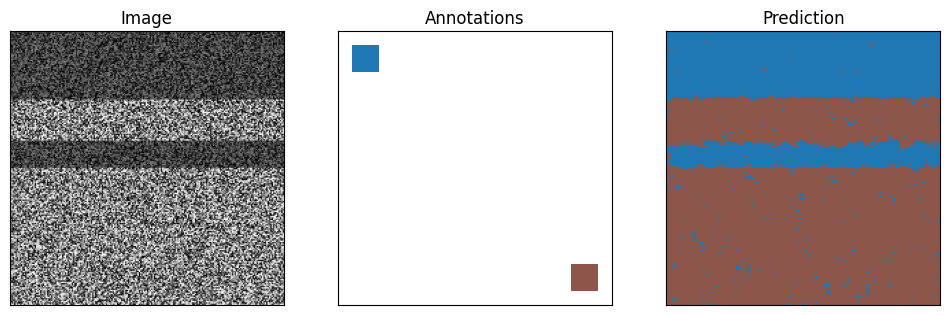

In [8]:
# show the image and the annotations
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Plot the image
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Image')

cmap = plt.cm.get_cmap('tab20', 3)
cmap.set_under('white')
# Plot the annotations
axes[1].imshow(annotations, cmap=cmap,interpolation='nearest',vmin=1,vmax=3)
axes[1].set_title('Annotations')

# Plot the prediction
axes[2].imshow(prediction, cmap=cmap,interpolation='nearest',vmin=1,vmax=3)
axes[2].set_title('Prediction')

#disable x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

The selected output layers have 64 and 64 output features and we use two scalings, so in total we have `(64+64)*2 = 256` features.

In [9]:
print(f"Number of features: {features_full.shape[1]}")

Number of features: 256


## Run Convpaint in a loop for batch processing

In [10]:
num_images = 10 # Number of images to generate

imgs = []
predictions = []

for i in range(num_images):
    # Create a noisy image
    img = np.random.rand(200, 200)
    start_row = np.random.randint(0, 150)
    end_row = start_row + np.random.randint(20, 50)
    img[start_row:end_row, :] = img[start_row:end_row, :] * 0.5
    
    # Make prediction
    prediction = model.predict_image(image=img,
                                     classifier=random_forest,
                                     param=param)
    
    imgs.append(img)
    predictions.append(prediction)

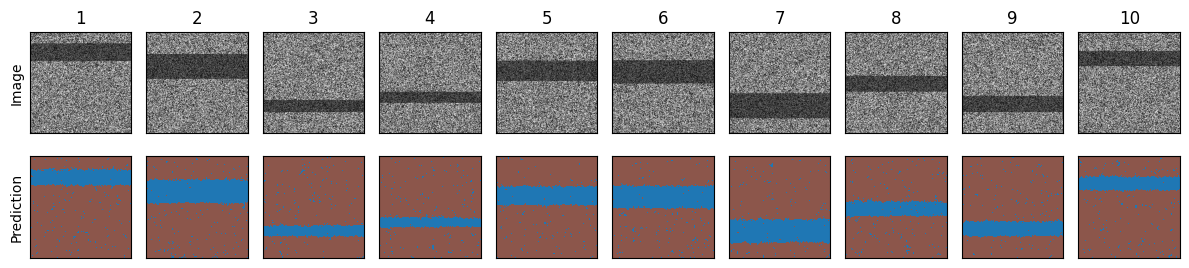

In [11]:


# Create a figure with a grid of subplots
fig, axs = plt.subplots(2, num_images, figsize=(12, 3))

for i in range(num_images):
    # Plot sample image
    axs[0, i].imshow(imgs[i], cmap='gray')
    axs[0, i].set_title(f'{i+1}')
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])


    
    # Plot prediction
    axs[1, i].imshow(predictions[i], cmap=cmap,interpolation='nearest',vmin=1,vmax=3)
    axs[1, i].set_title(f'')
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])


# Add y labels
axs[0, 0].set_ylabel('Image')
axs[1, 0].set_ylabel('Prediction')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Tip:</b> In Pertz Lab we train a model using the GUI on data live streamed from the microscope at the beginning of an experiment. The trained model is then used programmatically for smart microscopy approaches, for example enabling optogenetic stimulation of subcellular areas, or automated selection of cells that fit a certain shape criteria.

## Create a model using `DINOv2` as feature extractor

For the ViT based DINO model we don't have to select the layers, and can just extract the patch based features.

In [12]:
from napari_convpaint import conv_paint_param
import skimage
param = conv_paint_param.Param()
param.fe_name = 'dinov2_vits14_reg'
param.fe_scalings = [1]
param.fe_order = 0
param.image_downsample = 1


# create new dataset
img = skimage.data.stereo_motorcycle()
annotations = np.zeros(img[0][:,:,0].shape)
#foreground [y,x]
annotations[50:100,50:100] = 1
annotations[450:500,500:550] = 1
#background [x,y]
annotations[200:250,400:450] = 2
annotations[300:350,200:400] = 2


# create and train the model
model = conv_paint.create_model(param)
features, targets = conv_paint.get_features_current_layers(np.moveaxis(img[0],-1,0), annotations,
                                                model=model,
                                                param=param)

random_forest = conv_paint.train_classifier(features, targets)

prediction = model.predict_image(image=np.moveaxis(img[1],-1,0),
                                    classifier=random_forest,
                                    param=param)

/Users/luhin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/luhin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/luhin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


/var/folders/zy/d2yp5vws25l6vkr2g5l4t39c0000gn/T/ipykernel_65814/1021984278.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 3)


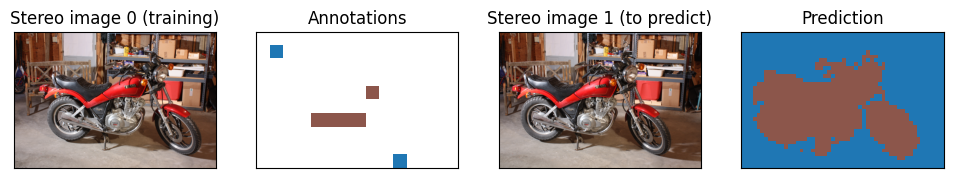

In [13]:
# show the image and the annotations
fig, axes = plt.subplots(1, 4, figsize=(12, 6))

# Plot the image
axes[0].imshow(img[0], cmap='gray')
axes[0].set_title('Stereo image 0 (training)')

cmap = plt.cm.get_cmap('tab20', 3)
cmap.set_under('white')

# Plot the annotations
axes[1].imshow(annotations, cmap=cmap,interpolation='nearest',vmin=1,vmax=3)
axes[1].set_title('Annotations')

# Plot the image to predict
axes[2].imshow(img[1], cmap='gray')
axes[2].set_title('Stereo image 1 (to predict)')


# Plot the prediction
axes[3].imshow(prediction, cmap=cmap,interpolation='nearest',vmin=1,vmax=3)
axes[3].set_title('Prediction')

#disable x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

## Visualize the extracted DINOv2 features

In [14]:
annotations_blank = np.ones(annotations.shape)
features, _ = conv_paint.get_features_current_layers(np.moveaxis(img[0],-1,0), annotations_blank,
                                                model=model,
                                                param=param)
features_image = np.reshape(features,(annotations.shape[0],annotations.shape[1],features.shape[1]))

Extracted 384 features.


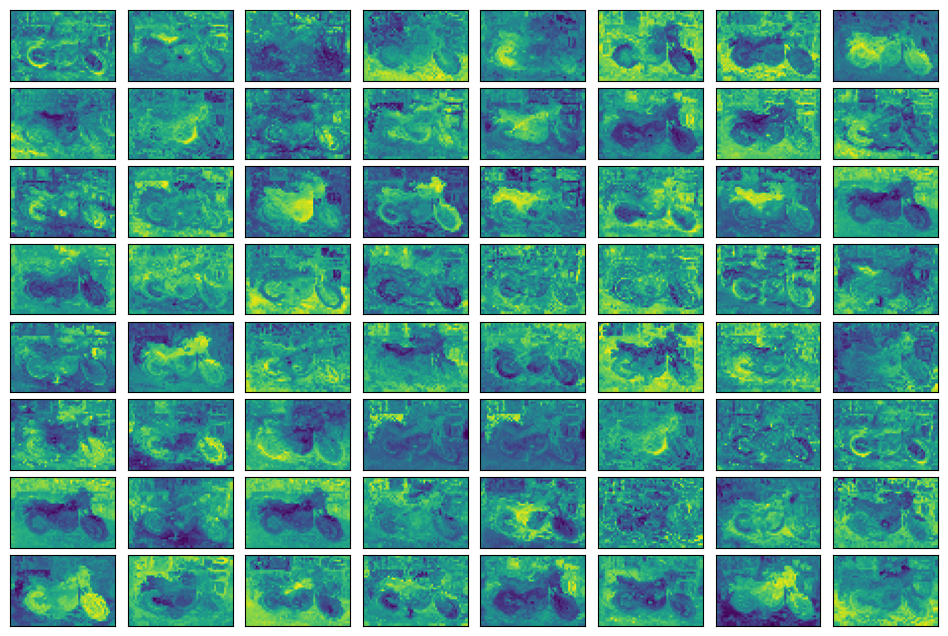

In [15]:
print(f"Extracted {features_image.shape[-1]} features.")
random_features = np.random.choice(features_image.shape[-1],8*8)
fig, axes = plt.subplots(8, 8, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(features_image[:,:,random_features[i]], cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])
#set w/h distance between subplots to 0
plt.subplots_adjust(wspace=0.1, hspace=0.1)


<div class="alert alert-block alert-info">
<b>Tip:</b> It can be usefult to visualize the extracted features for troubleshooting and getting an intuition, which level of detail the model considers. In this example, DINOv2 extracts high-level semantic features like tires, floor, whole bike or motor.

## Combine the features from multiple models
The strenghts of different feature extractors can be combined by simply concatenating their outputs. For example, the good spatial resolution of VGG16 can be combined with the rich semantic features of DINOv2. This leads to very good results on some datasets.

In [16]:
from napari_convpaint import conv_paint_param
import skimage
param_dino = conv_paint_param.Param()
param_dino.fe_name = 'dinov2_vits14_reg'
param_dino.fe_scalings = [1]
param_dino.fe_order = 0
param_dino.image_downsample = 1

param_vgg = conv_paint_param.Param()
param_vgg.fe_name = 'vgg16'
param_vgg.fe_scalings = [1,2,4]
param_vgg.fe_order = 0
param_vgg.fe_layers = ['features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))']
param_vgg.image_downsample = 1

img_0 = np.moveaxis(skimage.data.stereo_motorcycle()[0],-1,0)
img_1 = np.moveaxis(skimage.data.stereo_motorcycle()[1],-1,0) 

# create the feature extractor models and extract the features
model_dino = conv_paint.create_model(param_dino)
model_vgg = conv_paint.create_model(param_vgg)
features_dino, targets = conv_paint.get_features_current_layers(img_0, annotations,model_dino, param_dino)
features_vgg, targets = conv_paint.get_features_current_layers(img_0, annotations,model_vgg, param_vgg)

# combine the features from both models
features = np.concatenate((features_dino,features_vgg),axis=1)
random_forest = conv_paint.train_classifier(features, targets)

# predict on the second image
features_dino, _ = conv_paint.get_features_current_layers(img_1, annotations_blank, model_dino, param_dino)
features_vgg, _ = conv_paint.get_features_current_layers(img_1, annotations_blank, model_vgg, param_vgg)
features = np.concatenate((features_dino,features_vgg),axis=1)
prediction = random_forest.predict(features)
prediction = np.reshape(prediction,annotations.shape)

/var/folders/zy/d2yp5vws25l6vkr2g5l4t39c0000gn/T/ipykernel_65814/3271412963.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 3)


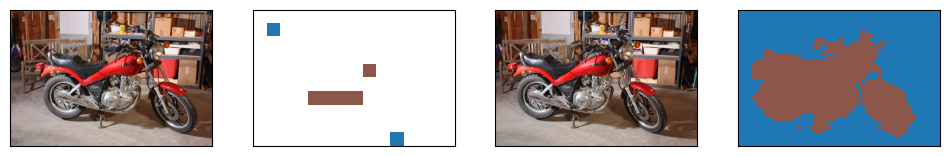

In [17]:
# show the image and the annotations
fig, axes = plt.subplots(1, 4, figsize=(12, 6))

# Plot the image
axes[0].imshow(img[0], cmap='gray')

cmap = plt.cm.get_cmap('tab20', 3)
cmap.set_under('white')

# Plot the annotations
axes[1].imshow(annotations, cmap=cmap,interpolation='nearest',vmin=1,vmax=3)

# Plot the image to predict
axes[2].imshow(img[1], cmap='gray')

# Plot the prediction
axes[3].imshow(prediction, cmap=cmap,interpolation='nearest',vmin=1,vmax=3)

#disable x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# Visual comparison of features extracted by DINOv2 and VGG16

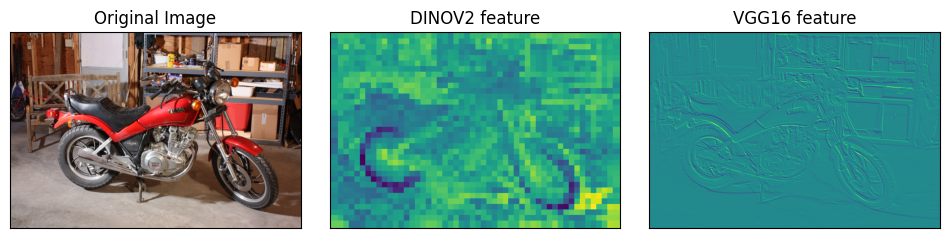

In [18]:
features_dino_image = np.reshape(features_dino,(annotations.shape[0],annotations.shape[1],features_dino.shape[1]))
features_vgg_image = np.reshape(features_vgg,(annotations.shape[0],annotations.shape[1],features_vgg.shape[1]))

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
#plot img, dinov2 and vgg16 features
axes[1].imshow(features_dino_image[:,:,15], cmap='viridis')
axes[1].set_title('DINOV2 feature')
axes[2].imshow(features_vgg_image[:,:,20], cmap='viridis')
axes[2].set_title('VGG16 feature')
axes[0].imshow(img[0])
axes[0].set_title('Original Image')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
